In [1]:
#データ作成
import pandas as pd
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=100,n_features=20,centers=15,cluster_std=2,shuffle=True,random_state=0)
variables = ['辛さ','重厚','スパイシー','果実味','コク','酸味','落ち着き','香り','華やか','ジューシー','熟成','透明感','シャープ','力強い','フレッシュ','渋み','苦味','樽','エキゾチック','粘性']
name = list(map(str,[i for i in range(100)]))
df = pd.DataFrame(X,columns=variables, index=name)

In [6]:
X.shape

(100, 20)

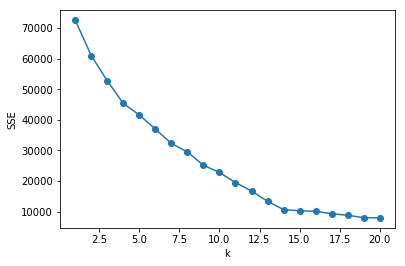

In [10]:
#何種類のワインを置くべきか、つまり幾つのクラスタに分けるべきか
#エルボー法
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
SSE = []
for i in range(1,21):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    km.fit(X)
    SSE.append(km.inertia_)

plt.plot(range(1,21),SSE,marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()
#14種類が良い、理由は１４種類以降がSSEの減少がほぼ無くなるため。

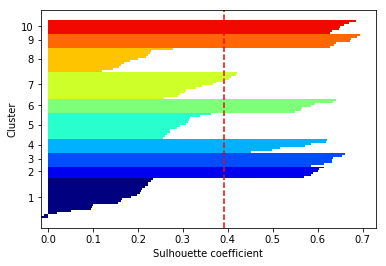

In [29]:
#シルエット法
km = KMeans(n_clusters=10, init='random', n_init=10, max_iter=300,tol=1e-04, random_state=0)
y_km = km.fit_predict(X)
from matplotlib import cm
from sklearn.metrics import silhouette_samples
import numpy as np
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')
y_ax_lower,y_ax_upper=0,0
yticks = []
for i,c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower , y_ax_upper), c_silhouette_vals, height=1, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red',linestyle='--')
plt.yticks(yticks,cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Sulhouette coefficient')
plt.show()
#全部ダメそう。このデータセットには合わなそう。

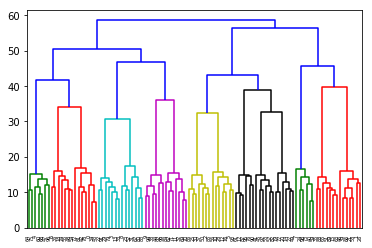

In [25]:
#樹木図(dendrogram)、X軸はデータ、y軸は距離
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
row_clusters = linkage(pdist(df,metric='euclidean'),method='complete')
row_dender = dendrogram(row_clusters, labels=name)
plt.show()
#8種類が良さそう。理由は距離が２０以下のあたりである程度まとっまたツリーが８個あるため。

In [33]:
#中心点（セントロイド）
print(km.cluster_centers_)

[[  4.61454958e+00  -1.36708835e+00  -3.88305921e+00   7.56891014e+00
    4.01398909e-01   3.82977237e+00  -6.00711012e+00   6.83855094e+00
   -2.21535317e-01   2.80155720e+00  -1.23212306e+00   6.64326062e+00
   -3.76269871e+00   4.39474948e+00  -7.82681311e+00   5.37918558e+00
    5.49215982e+00   2.84689658e+00   3.08203188e+00  -6.29039493e-03]
 [ -3.98515950e+00   3.64662093e+00  -2.81515219e+00  -5.93571671e+00
   -1.00686073e+01  -7.58927701e+00   3.77698347e+00   3.25079646e-01
    2.72791813e-01   8.38638261e+00   9.43331675e+00  -6.16555551e+00
    4.52621510e+00  -4.33961085e+00  -1.05187087e+01   4.96822824e+00
   -3.06374514e+00  -3.54938475e+00   1.95098158e+00   7.63583930e+00]
 [ -6.12383897e+00   3.83093929e+00   2.41043815e+00  -5.72034766e+00
    7.43954562e+00   3.32690060e+00  -9.39025644e-01   1.43531692e+00
    4.79055649e+00  -2.85489462e+00  -2.75567433e+00  -4.74798336e+00
   -6.66552029e+00   8.69498272e+00   5.99214778e+00  -6.47750019e-01
   -5.84287191e+00

In [37]:
#決定木分析の実行
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X,y_km)
predictes = clf.predict(X)
tree.export_graphviz(clf,out_file='tree.dot',
                    feature_names=variables,
                    class_names=name,
                    filled=True, rounded=True)